**Import Dependencies**

In [ ]:
!pip install -Uqq pythainlp

     |████████████████████████████████| 11.0 MB 23.5 MB/s 
     |████████████████████████████████| 743 kB 59.3 MB/s 


In [ ]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

--2021-12-07 17:08:48--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2021-12-07 17:08:48--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.002s  

2021-12-07 17:08:48 (48.5 MB/s) - ‘t

In [ ]:
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from pythainlp.corpus.common import thai_stopwords
from pythainlp import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from pythainlp.util import normalize
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [ ]:
warnings.filterwarnings('ignore')

**Import Google Sheets**

In [ ]:
sheet_name = 'questions'

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open(sheet_name).sheet1
content = worksheet.get_all_values()

**Create Dataframe**

In [ ]:
data = pd.DataFrame.from_records(content)
data.columns = data.iloc[0]
data = data[1:]
data.head()

,question,choice,topic
1,นาย ก. กับนาย ข. ออกแรงลากวัตถุชิ้นหนึ่งไปในทา...,1) 300\n2) 200\n3) 150\n4) 100,แรงและการเคลื่อนที่
2,นาย ก. ออกแรง 300 N ไปทางทิศเหนือ นาย ข. ออกแร...,"1) 350\n2) 500\n3) 700\n4) 1,200",แรงและการเคลื่อนที่
3,นาย ก. ออกแรง 100 N ไปทางทิศเหนือ นาย ข. ออกแร...,"1) 35 N, ทิศตะวันออกเฉียงเหนือ\n2) 50 N, ทิศตะ...",แรงและการเคลื่อนที่
4,หากต้องการเคลื่อนย้ายโต๊ะโดยลากไปบนพื้น การกระ...,"1) ก., ข. และ ค.\n2) ก. และ ข.\n3) ก. และ ค.\n...",แรงและการเคลื่อนที่
5,ข้อใดถูกต้องเกี่ยวกับการโยนวัตถุขึ้นไปตามแนวดิ่ง,1) โยนวัตถุขึ้นในแนวดิ่ง ความเร็วต้นมีค่าน้อยก...,แรงและการเคลื่อนที่


**Understanding features and target variables**

In [ ]:
data.shape

(320, 3)

In [ ]:
data.dtypes

0
question    object
choice      object
topic       object
dtype: object

**Checking for NULL values**

In [ ]:
data.replace('', float('NaN'), inplace=True)
data.isnull().any()

0
question    False
choice      False
topic       False
dtype: bool

**Drop row that contains NaN value**

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().any()

0
question    False
choice      False
topic       False
dtype: bool

In [ ]:
data.shape

(320, 3)

**Combine question's column and choice's column into text's column**

In [ ]:
data['text'] = data['question'] + data['choice']

data.head()

,question,choice,topic,text
1,นาย ก. กับนาย ข. ออกแรงลากวัตถุชิ้นหนึ่งไปในทา...,1) 300\n2) 200\n3) 150\n4) 100,แรงและการเคลื่อนที่,นาย ก. กับนาย ข. ออกแรงลากวัตถุชิ้นหนึ่งไปในทา...
2,นาย ก. ออกแรง 300 N ไปทางทิศเหนือ นาย ข. ออกแร...,"1) 350\n2) 500\n3) 700\n4) 1,200",แรงและการเคลื่อนที่,นาย ก. ออกแรง 300 N ไปทางทิศเหนือ นาย ข. ออกแร...
3,นาย ก. ออกแรง 100 N ไปทางทิศเหนือ นาย ข. ออกแร...,"1) 35 N, ทิศตะวันออกเฉียงเหนือ\n2) 50 N, ทิศตะ...",แรงและการเคลื่อนที่,นาย ก. ออกแรง 100 N ไปทางทิศเหนือ นาย ข. ออกแร...
4,หากต้องการเคลื่อนย้ายโต๊ะโดยลากไปบนพื้น การกระ...,"1) ก., ข. และ ค.\n2) ก. และ ข.\n3) ก. และ ค.\n...",แรงและการเคลื่อนที่,หากต้องการเคลื่อนย้ายโต๊ะโดยลากไปบนพื้น การกระ...
5,ข้อใดถูกต้องเกี่ยวกับการโยนวัตถุขึ้นไปตามแนวดิ่ง,1) โยนวัตถุขึ้นในแนวดิ่ง ความเร็วต้นมีค่าน้อยก...,แรงและการเคลื่อนที่,ข้อใดถูกต้องเกี่ยวกับการโยนวัตถุขึ้นไปตามแนวดิ...


**Map topics into numerical values**

In [ ]:
topics = list(data['topic'].unique())

topics

['แรงและการเคลื่อนที่',
 'งานและพลังงาน',
 'พลังงานไฟฟ้า',
 'ชีวิตและสิ่งแวดล้อม',
 'หน่วยของสิ่งมีชีวิตและการดำรงชีวิตของพืช',
 'อาหารและการดำรงชีวิต',
 'ระบบในร่างกายมนุษย์และสัตว์',
 'การสืบพันธ์และการถ่ายทอดลักษณะทางพันธุกรรม']

In [ ]:
topics_dict = {i:topics[i] for i in range(len(topics))}

topics_dict

{0: 'แรงและการเคลื่อนที่',
 1: 'งานและพลังงาน',
 2: 'พลังงานไฟฟ้า',
 3: 'ชีวิตและสิ่งแวดล้อม',
 4: 'หน่วยของสิ่งมีชีวิตและการดำรงชีวิตของพืช',
 5: 'อาหารและการดำรงชีวิต',
 6: 'ระบบในร่างกายมนุษย์และสัตว์',
 7: 'การสืบพันธ์และการถ่ายทอดลักษณะทางพันธุกรรม'}

In [ ]:
data['topic_id'] = data.apply(lambda row: topics.index(row['topic']), axis=1)

data.head()

,question,choice,topic,text,topic_id
1,นาย ก. กับนาย ข. ออกแรงลากวัตถุชิ้นหนึ่งไปในทา...,1) 300\n2) 200\n3) 150\n4) 100,แรงและการเคลื่อนที่,นาย ก. กับนาย ข. ออกแรงลากวัตถุชิ้นหนึ่งไปในทา...,0
2,นาย ก. ออกแรง 300 N ไปทางทิศเหนือ นาย ข. ออกแร...,"1) 350\n2) 500\n3) 700\n4) 1,200",แรงและการเคลื่อนที่,นาย ก. ออกแรง 300 N ไปทางทิศเหนือ นาย ข. ออกแร...,0
3,นาย ก. ออกแรง 100 N ไปทางทิศเหนือ นาย ข. ออกแร...,"1) 35 N, ทิศตะวันออกเฉียงเหนือ\n2) 50 N, ทิศตะ...",แรงและการเคลื่อนที่,นาย ก. ออกแรง 100 N ไปทางทิศเหนือ นาย ข. ออกแร...,0
4,หากต้องการเคลื่อนย้ายโต๊ะโดยลากไปบนพื้น การกระ...,"1) ก., ข. และ ค.\n2) ก. และ ข.\n3) ก. และ ค.\n...",แรงและการเคลื่อนที่,หากต้องการเคลื่อนย้ายโต๊ะโดยลากไปบนพื้น การกระ...,0
5,ข้อใดถูกต้องเกี่ยวกับการโยนวัตถุขึ้นไปตามแนวดิ่ง,1) โยนวัตถุขึ้นในแนวดิ่ง ความเร็วต้นมีค่าน้อยก...,แรงและการเคลื่อนที่,ข้อใดถูกต้องเกี่ยวกับการโยนวัตถุขึ้นไปตามแนวดิ...,0


**Count and plot target variables**

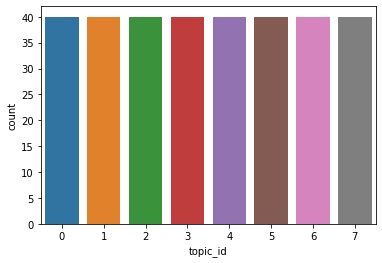

In [ ]:
sns.countplot(data.topic_id)

**Cleaning the data**

In [ ]:
thai_stopwords = list(thai_stopwords())

In [ ]:
custom_stopwords = ['นาย',
                    'ก',
                    'ข',
                    'ค',
                    'ง',
                    'ข้อ', 'ต่อไปนี้', 'คำตอบ', 'ใด']

stopwords = thai_stopwords + custom_stopwords
f'sum of stopwords = {len(stopwords)}, example : {stopwords[-10:]}'

"sum of stopwords = 1039, example : ['จากนี้', 'นาย', 'ก', 'ข', 'ค', 'ง', 'ข้อ', 'ต่อไปนี้', 'คำตอบ', 'ใด']"

In [ ]:
def text_process(text):
  ftext = text.replace('\n', '')
  ftext = ftext.replace('\t', '')
  ftext = ftext.replace('\r', '')
  ftext = ''.join(u for u in ftext if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ", ")", "(", "+", "-", "/", ",", "=", "⋅", "“", "”"))
  ftext = ''.join([i for i in ftext if not i.isdigit()])
  ftext = ftext.lower()
  ftext = word_tokenize(ftext, keep_whitespace=False)
  for word in ftext: word = normalize(word)
  ftext = ' '.join(word for word in ftext if word not in stopwords)

  return ftext

text_process(data['text'].tolist()[76])

'นุช ทำงาน จูล เวลา นาที วินาที นุช ใช้กำลัง กี่ วัตต์'

In [ ]:
data['text_tokens'] = data['text'].apply(text_process)

data.head()

,question,choice,topic,text,topic_id,text_tokens
1,นาย ก. กับนาย ข. ออกแรงลากวัตถุชิ้นหนึ่งไปในทา...,1) 300\n2) 200\n3) 150\n4) 100,แรงและการเคลื่อนที่,นาย ก. กับนาย ข. ออกแรงลากวัตถุชิ้นหนึ่งไปในทา...,0,ออกแรง ลาก วัตถุ ชิ้น ออกแรง n ออกแรง n วัตถุ ...
2,นาย ก. ออกแรง 300 N ไปทางทิศเหนือ นาย ข. ออกแร...,"1) 350\n2) 500\n3) 700\n4) 1,200",แรงและการเคลื่อนที่,นาย ก. ออกแรง 300 N ไปทางทิศเหนือ นาย ข. ออกแร...,0,ออกแรง n ทิศเหนือ ออกแรง ขนาด n ทิศตะวันออก วั...
3,นาย ก. ออกแรง 100 N ไปทางทิศเหนือ นาย ข. ออกแร...,"1) 35 N, ทิศตะวันออกเฉียงเหนือ\n2) 50 N, ทิศตะ...",แรงและการเคลื่อนที่,นาย ก. ออกแรง 100 N ไปทางทิศเหนือ นาย ข. ออกแร...,0,ออกแรง n ทิศเหนือ ออกแรง n ทางทิศใต้ ออกแรง n ...
4,หากต้องการเคลื่อนย้ายโต๊ะโดยลากไปบนพื้น การกระ...,"1) ก., ข. และ ค.\n2) ก. และ ข.\n3) ก. และ ค.\n...",แรงและการเคลื่อนที่,หากต้องการเคลื่อนย้ายโต๊ะโดยลากไปบนพื้น การกระ...,0,ต้องการ เคลื่อนย้าย โต๊ะ ลาก พื้น การกระทำ ออก...
5,ข้อใดถูกต้องเกี่ยวกับการโยนวัตถุขึ้นไปตามแนวดิ่ง,1) โยนวัตถุขึ้นในแนวดิ่ง ความเร็วต้นมีค่าน้อยก...,แรงและการเคลื่อนที่,ข้อใดถูกต้องเกี่ยวกับการโยนวัตถุขึ้นไปตามแนวดิ...,0,การโยน วัตถุ ขึ้นไป แนวดิ่ง โยน วัตถุ แนวดิ่ง ...


**Check for NULL**

In [ ]:
data.replace(' ', '', inplace=True)
data.replace('', float('NaN'), inplace=True)
data.isnull().any()

0
question       False
choice         False
topic          False
text           False
topic_id       False
text_tokens    False
dtype: bool

**Create WordCloud**


In [ ]:
def create_wordcloud(id_topic):

  topic_df = data[data.topic_id == id_topic]
  topic_word_all = ' '.join(text for text in topic_df['text_tokens'])
  reg = r"[ก-๙a-zA-Z']+"
  fp = '/content/thsarabunnew-webfont.ttf'

  wordcloud = WordCloud(background_color = 'white', 
                        max_words=2000, 
                        height = 600, 
                        width= 800,
                        max_font_size=100,
                        font_path=fp, 
                        regexp=reg).generate(topic_word_all)

  print(topics_dict[id_topic])
  plt.figure(figsize = (16,8))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

งานและพลังงาน


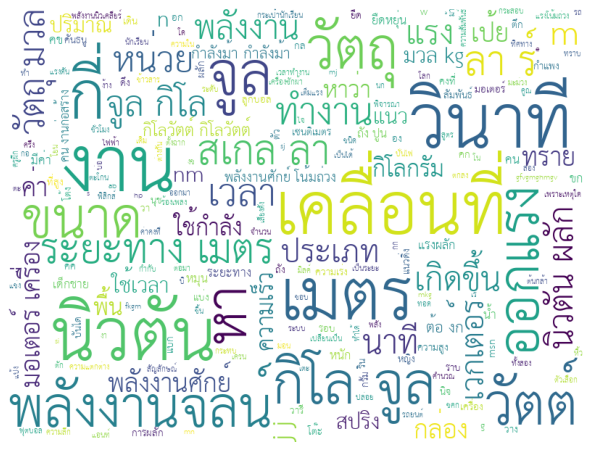

In [ ]:
create_wordcloud(1)

**Split data into train set(80%) and test set(20%)**


In [ ]:
x = data['text_tokens']
y = data['topic_id']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((224,), (224,), (96,), (96,))

**Word Vectorization**

In [ ]:
cvec = CountVectorizer(analyzer=lambda x:x.split(' '))
cvec.fit_transform(x_train)
cvec.vocabulary_

In [ ]:
train_bow = cvec.transform(x_train)
pd.DataFrame(train_bow.toarray(), columns=cvec.get_feature_names(), index=x_train).head()

,%,a,ab,action,adek,b,binary,buoyant,c,callus,cell,centripetal,co,e,fe,fission,fkgm,force,fsh,g,gfvgmghmgv,h,hp,j,kg,l,lh,m,mg,mj,mkg,mn,monet,ms,msn,n,nm,npkmg,o,oc,...,ไข่แดง,ไค,ไจ,ไซ,ไซบีเรีย,ไซโกต,ไดนาโม,ได้ดี,ได้ประโยชน์,ไต,ไต่,ไท,ไทย,ไน,ไนโตรเจน,ไบ,ไปมา,ไฟ,ไฟฟ้า,ไฟฟ้าลัดวงจร,ไฟฟ้าแรงสูง,ไมโทคอนเดรีย,ไม่ต้องการ,ไม้,ไม้กวาด,ไรน้ำ,ไรโบโซม,ไล,ไลโซโซม,ไส้เดือน,ไส้เดือนดิน,ไหม,ไหล,ไหลผ่าน,ไอ,ไอโอดีน,ไฮดรอกไซด์,ไฮดรา,ไฮโดรเจน,์
text_tokens,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
เพราะเหตุใด หญิง มีครรภ์ หญิง ให้นม บุตร ความต้องการ ธาตุ fe จำนวน mg หญิง ธรรมดา mg ความต้องการ อาหาร แต่ละคน ส่วนประกอบ สร้าง น้ำนม สำหรับ ลูก สร้าง กระดูก ฟัน สำหรับ ลูก สร้าง เฮโมโกลบิน เม็ดเลือดแดง ลูก,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
โพลาร์ นิว คลี โอ เซลล์ นิวเคลียส เซลล์ นิวเคลียส เซลล์ นิวเคลียส เซลล์ นิวเคลียส,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
งาน เกิดขึ้น โด เร ม่อน ผลัก กล่อง แป้ง ทอด ขอบ โต๊ะ โน บิ ตะ โยน ลูกบอล ไจ แอนท์ ตะโกน ร้องเพลง เสียงดัง ต้อ งก ขก คข คค,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
เป้ย วัตถุ มวล kg วาง ที่สูง พื้น เมตร ทราย วัตถุ มวล kg วาง ที่สูง พื้น เมตร เป้ย ทราย ทำงาน มีค่า ความแตกต่าง พลังงาน กี่ จูล เป้ย งาน ทราย จูล เป้ย งาน ทราย จูล ทราย งาน เป้ย จูล ทราย งาน เป้ย จูล,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
คน ปกติ ความดันเลือด หัวใจ เลือด กี่ มิลลิเมตร ปรอท มิลลิเมตร ปรอท มิลลิเมตร ปรอท มิลลิเมตร ปรอท มิลลิเมตร ปรอท,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Model building**

In [ ]:
lr = LogisticRegression()
lr.fit(train_bow, y_train)

LogisticRegression()

In [ ]:
test_bow = cvec.transform(x_test)
test_predictions = lr.predict(test_bow)
print(classification_report(test_predictions, y_test))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.67      0.67      0.67         9
           2       0.83      1.00      0.91        10
           3       0.73      0.80      0.76        10
           4       0.88      0.93      0.90        15
           5       0.78      0.54      0.64        13
           6       0.92      0.80      0.86        15
           7       0.75      0.90      0.82        10

    accuracy                           0.80        96
   macro avg       0.79      0.80      0.79        96
weighted avg       0.80      0.80      0.80        96



0: 'แรงและการเคลื่อนที่',
1: 'งานและพลังงาน',
2: 'พลังงานไฟฟ้า',
3: 'ชีวิตและสิ่งแวดล้อม',
4: 'หน่วยของสิ่งมีชีวิตและการดำรงชีวิตของพืช',
5: 'อาหารและการดำรงชีวิต',
6: 'ระบบในร่างกายมนุษย์และสัตว์',
7: 'การสืบพันธ์และการถ่ายทอดลักษณะทางพันธุกรรม'

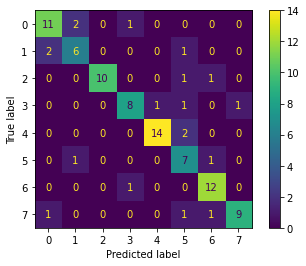

In [ ]:
cm = confusion_matrix(y_test, test_predictions)
ConfusionMatrixDisplay(cm).plot()
plt.show()

**Test input**

In [ ]:
user_question = input('question : ')
test_bow = cvec.transform([user_question])
test_predictions = lr.predict(test_bow)

print(f"topic : {topics_dict[test_predictions[0]]}")

question : นาย ก. ออกแรง 100 N ไปทางทิศเหนือ นาย ข. ออกแรง 70 N ไปทางทิศใต้ นาย ค. ออกแรง 50 N ไป      ทางทิศตะวันออก นาย ง. ออกแรง 10 N ไปทางทิศตะวันตก โดยกระทำที่จุดเดียวกัน แรงลัพธ์มีค่ากี่ N         อยู่ประมาณทิศใด
topic : แรงและการเคลื่อนที่
